# Deepwalk Implementation


In [16]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
from torch import tensor, Tensor
from utils.deepwalk import DeepwalkModel, train_deepwalk
from torch.multiprocessing import cpu_count
from sklearn.manifold import TSNE
import pandas as pd

Các Hyperparameter


In [17]:
EMBEDDING_SIZE = 64
WALK_LENGTH = 10
WALKS_PER_VERTEX = 10
WINDOW_SIZE = 3
START_LEARNING_RATE = 0.025
END_LEARNING_RATE = 0.001
# Tiền xử lý 1D embedding
PREPROCESS_WALKS_PER_VERTEX = 10
# Dùng cho TSNE
PERPLEXITY = 20

device và worker_threads


In [18]:
WORKER_THREADS = torch.cuda.device_count(
) if torch.cuda.is_available() else cpu_count()


WORKER_THREADS = 1


CHUNK_SIZE = 4


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)



print(WORKER_THREADS)

cpu
1


Load dataset


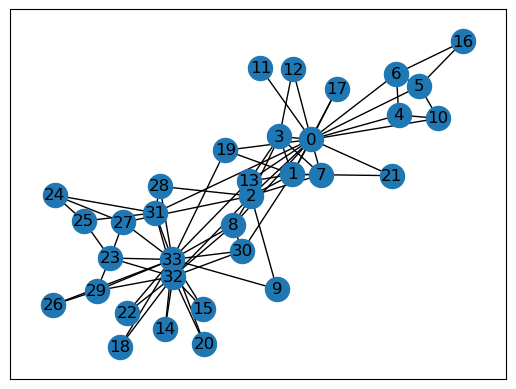

In [19]:
# Load dataset
# karate club
g: nx.Graph = nx.karate_club_graph()
adj_lists = [list(g.neighbors(v)) for v in g]
vertices = list(g)
V = len(g)
nx.draw_networkx(g)

### 1D Embedding

Embedding n-D bằng Deepwalk -> Embedding 1D bằng TSNE -> Sắp xếp lại thứ tự lá của Hierarchical Softmax


In [20]:
# ánh xạ từ đỉnh -> vị trí lá
leaf_pos = list(range(V))

# embedding sẽ được chuyển về 1 chiều bằng TSNE
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=(START_LEARNING_RATE + END_LEARNING_RATE) / 2.0,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=PREPROCESS_WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

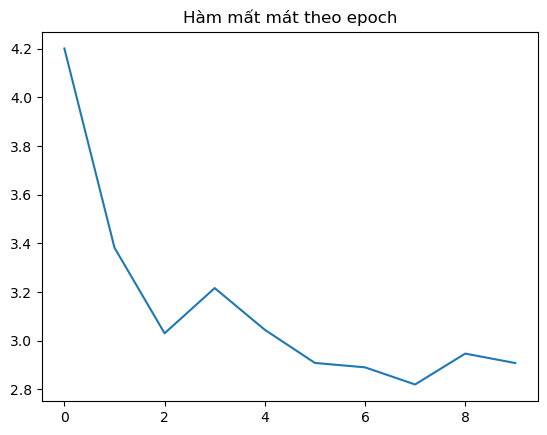

In [21]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

Chyển embedding về 1 chiều bằng TSNE rồi cập nhật lại vị trí lá cho Hierarchical Softmanx


In [22]:
# chuyển embedding về 1 chiều
emb: Tensor = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb = TSNE(n_components=1, perplexity=PERPLEXITY).fit_transform(emb).flatten()

# sắp xếp thứ tự các đỉnh
vertices.sort(key=lambda v: emb[v])

# cập nhật thứ tự lá cho các đỉnh
for pos, v in enumerate(vertices):
    leaf_pos[v] = pos

print(emb)
print(vertices)
print(leaf_pos)

[-1.7352183 -1.5448467 -1.549075  -1.2085676 -1.2339114 -2.698026
 -3.6593726 -2.0009904 -2.5967448 -3.043036  -3.3442628 -3.1902099
 -2.3468542 -1.4706658 -1.1498009 -1.9197768 -3.1834865 -1.6449152
 -3.0660405 -1.6189711 -2.3992515 -1.0033084 -2.6641207 -1.8469322
 -2.3870006 -2.3702428 -0.9032553 -1.9228057 -2.5059106 -2.0377886
 -2.524917  -2.2134545 -2.5506983 -2.4956412]
[6, 10, 11, 16, 18, 9, 5, 22, 8, 32, 30, 28, 33, 20, 24, 25, 12, 31, 29, 7, 27, 15, 23, 0, 17, 19, 2, 1, 13, 4, 3, 14, 21, 26]
[23, 27, 26, 30, 29, 6, 0, 19, 8, 5, 1, 2, 16, 28, 31, 21, 3, 24, 4, 25, 13, 32, 7, 22, 14, 15, 33, 20, 11, 18, 10, 17, 9, 12]


### n-D Embedding


In [23]:
model = DeepwalkModel(V=V, emb_sz=EMBEDDING_SIZE, leaf_pos=leaf_pos).to(device)
loss_records = []

if WORKER_THREADS > 1:
    model.share_memory()
train_deepwalk(
    model=model,
    start_lr=START_LEARNING_RATE,
    end_lr=END_LEARNING_RATE,
    vertices=vertices,
    adj_lists=adj_lists,
    loss_records=loss_records,
    walk_len=WALK_LENGTH,
    walks_per_vertex=WALKS_PER_VERTEX,
    window_sz=WINDOW_SIZE,
    worker_threads=WORKER_THREADS,
    chunk_sz=CHUNK_SIZE,
)

100%|██████████| 10/10 [00:12<00:00,  1.20s/it]


Text(0.5, 1.0, 'Hàm mất mát theo epoch')

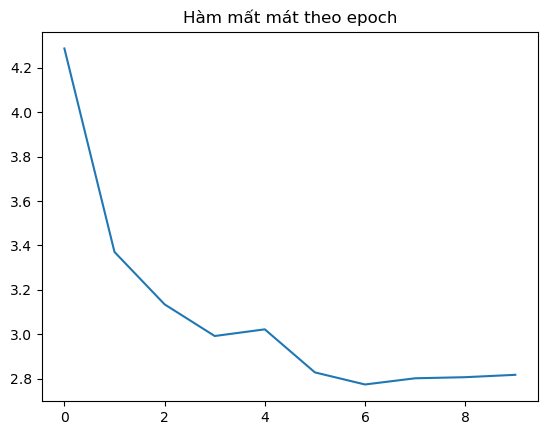

In [24]:
plt.tick_params("y")
plt.plot(loss_records)
plt.title("Hàm mất mát theo epoch")

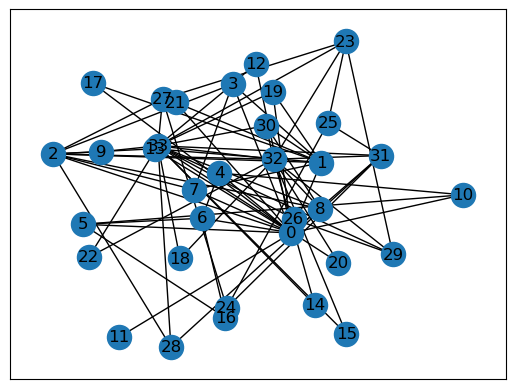

In [25]:
emb = model.embedding_layer(tensor(list(g))).detach().cpu().numpy()
emb_2d = TSNE(n_components=2, perplexity=PERPLEXITY).fit_transform(emb)
pos = {v: v_emb for v, v_emb in enumerate(emb_2d)}

nx.draw_networkx(g, pos)

In [29]:
df = pd.DataFrame(emb)
df.to_csv("out/karate_emb.csv", header=False, index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.421854,2.709823,1.618245,1.333783,0.068340,1.010984,-0.136381,0.565877,-0.873339,-0.695178,...,-0.632117,-0.541632,0.490608,-0.522217,-0.090622,0.121117,-2.513435,-0.306797,1.088820,1.144073
1,-0.327551,-0.050743,-0.395427,-1.335476,-0.431725,1.128078,0.346949,-0.581557,0.254305,-0.738695,...,-0.535141,-0.366746,0.853866,-1.250258,-1.312741,-1.541080,0.069323,-1.046414,1.174399,0.100007
2,-0.360330,-0.795405,-1.956285,-0.466381,-0.694307,1.232850,-0.321396,1.381249,2.199413,-0.033529,...,0.309707,1.795208,-0.177598,0.391252,0.779562,0.699012,0.435354,-0.356331,-0.704529,0.124278
3,-0.870658,-1.360336,1.888402,0.438327,0.861926,0.490410,-1.043532,-0.698862,-1.277273,1.211567,...,0.118431,0.241237,-0.344805,1.142339,0.250896,-0.062421,0.395541,0.331286,-0.308611,-0.996169
4,-1.746648,0.252035,0.858090,1.378005,1.488309,-0.199667,-1.051665,0.566517,0.905540,-0.759724,...,0.521024,-1.749733,0.073114,0.747788,1.102491,-0.755746,-0.596181,0.079882,-0.745887,-0.172947
5,0.284414,-0.079571,-1.774319,0.347904,-0.442720,0.295053,1.385878,0.498557,0.941887,-0.917183,...,0.048352,-0.043497,0.178136,0.609606,0.781620,0.100609,-0.059733,-0.470998,-1.355018,0.904277
6,-0.197859,2.605669,-1.747996,0.175280,-1.548645,0.023400,0.173694,-1.394194,-0.208969,0.691224,...,0.538671,-0.127789,0.212020,0.822830,-1.605840,0.935028,0.093822,0.426161,0.437465,-1.034079
7,-1.325977,1.531872,-0.772907,0.667907,1.089109,-0.760864,1.126717,0.174236,-1.080367,0.602907,...,-0.491179,0.792097,0.633805,0.888618,-0.071673,0.384401,1.142644,-1.184019,-0.512300,-0.865935
8,-0.089922,1.475504,-0.349852,-0.165180,-0.625187,0.440940,1.774187,0.505024,0.327404,-1.215833,...,-0.600156,0.280890,0.174275,-1.619005,-1.442337,-0.647212,0.275921,-0.457335,-0.128273,0.572196
9,-0.914266,-0.550953,-0.704259,1.996372,-0.037859,-0.326658,0.464236,-0.417187,-0.438700,0.817585,...,1.546283,2.365128,0.922597,0.413115,1.108835,0.600859,0.933841,-0.260982,-0.363435,-0.954676
